In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from metrics import mia_efficacy
import data
from models import get_model
from metrics import calculate_accuracy

/ibex/scratch/gasanoe/unlearning/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Collecting metrics

In [3]:
log_dir_dict_finetuned = {
    'SCRUB': '/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_untrain07-29-17:50:31_SCRUB',
    'neggradplus': '/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.2_untrain07-29-18:01:21_neggradplus',
    'our_method': '/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.01_untrain07-29-17:39:51_constrained_lagrange'
}

## Downloading the dataset

In [5]:
# Define CIFAR100 dataset handler
dataset_handler = data.CIFAR100Handler(batch_size=128,
                                           validation_split=0.1,
                                           random_seed=42,
                                           data_dir='/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/data/cifar100')
# data_confuser = data.uniform_confuser(confuse_level=.0, random_seed=42)
data_confuser = data.uniform_confuser(confuse_level=.1, random_seed=42)
splitter = data.mix_both_sets(
        amend_split=1.,
        # retain_split=0.1,
        retain_split=0.,
        random_seed=42
        )
confused_dataset_handler = data.AmendedDatasetHandler(
        dataset_handler,
        data_confuser,
        splitter
        )
train_loader, val_loader, test_loader, forget_loader, \
retain_loader, unseen_loader = confused_dataset_handler.get_dataloaders()

Files already downloaded and verified
Files already downloaded and verified


## Collecting metrics

In [7]:
all_values_retain_top5 = {}

In [8]:
def return_acc(weight_path, loader, k=5):
    model = get_model('resnet18', num_classes=100, pretrained_weights=None,
                      weight_path=weight_path)
    model.eval()
    device = torch.device('cuda')
    model.to(device)
    n_batches = 0
    full_acc = []
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        acc = calculate_accuracy(outputs, targets, topk=(k,))
        full_acc += acc
        n_batches += 1
    return (sum(full_acc) / len(full_acc)).item()

In [9]:
for key in ['SCRUB', 'neggradplus', 'our_method']:
    weight_path=log_dir_dict_finetuned[key]+'_model.pth'
    all_values_retain_top5[key] = return_acc(weight_path, retain_loader, k=5)

Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_untrain07-29-17:50:31_SCRUB_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812
Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.2_untrain07-29-18:01:21_neggradplus_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812
Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.01_untrain07-29-17:39:51_constrained_lagrange_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812


In [10]:
all_values_retain_top5

{'SCRUB': 82.74600982666016,
 'neggradplus': 77.54044342041016,
 'our_method': 79.07524108886719}

In [11]:
all_values_forget_top5 = {}

In [12]:
for key in ['SCRUB', 'neggradplus', 'our_method']:
    weight_path=log_dir_dict_finetuned[key]+'_model.pth'
    all_values_forget_top5[key] = return_acc(weight_path, forget_loader, k=5)

Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_untrain07-29-17:50:31_SCRUB_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812
Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.2_untrain07-29-18:01:21_neggradplus_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812
Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.01_untrain07-29-17:39:51_constrained_lagrange_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812


In [13]:
all_values_forget_top5

{'SCRUB': 16.6015625, 'neggradplus': 7.7880859375, 'our_method': 5.56640625}

In [14]:
all_values_validation_top5 = {}

In [15]:
for key in ['SCRUB', 'neggradplus', 'our_method']:
    weight_path=log_dir_dict_finetuned[key]+'_model.pth'
    all_values_validation_top5[key] = return_acc(weight_path, val_loader, k=5)

Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_untrain07-29-17:50:31_SCRUB_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812
Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.2_untrain07-29-18:01:21_neggradplus_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812
Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.01_untrain07-29-17:39:51_constrained_lagrange_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812


In [16]:
all_values_validation_top5

{'SCRUB': 61.65941619873047,
 'neggradplus': 59.4343376159668,
 'our_method': 65.81289672851562}

# Radar charts

In [17]:
# Sample data
labels = ['How well \n the model \n performs on \n unseen data', 'Accuracy \n on ' + r'$Data_A$', 'Accuracy \n on ' + r'$Data_B$']
categories = log_dir_dict_finetuned.keys()
my_data = dict()
for key in categories:
    my_data[key] = [all_values_validation_top5[key], 
                    all_values_retain_top5[key],
                    all_values_forget_top5[key]]
# data = {
#     'Finetuning': [80, 85, 40, 90],
#     'Fisher': [70, 80, 35, 85],
#     'NegGrad+': [85, 90, 50, 95],
#     'CF-k': [60, 65, 30, 75],
#     'EU-k': [75, 80, 45, 85],
#     'Bad-T': [50, 55, 20, 60],
#     'SCRUB': [90, 95, 55, 100]
# }

In [18]:
# Number of variables
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

In [19]:
angles += angles[:1]

In [20]:
angles

[0.0, 2.0943951023931953, 4.1887902047863905, 0.0]

In [21]:
categories

dict_keys(['SCRUB', 'neggradplus', 'our_method'])

In [37]:
categories_name = {'SCRUB':'SCRUB', 'neggradplus':'NegGrad+', 'our_method': 'Constrained (OUR)'}
categories = ['SCRUB', 'neggradplus', 'our_method']

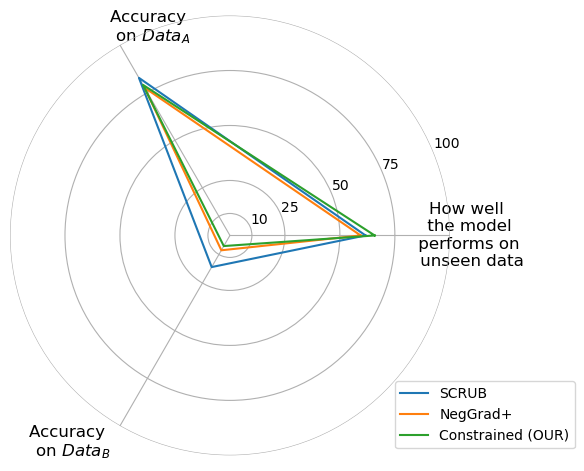

In [24]:
# Initialize the radar plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))



# Plot each category
for category in categories:
    values = copy.deepcopy(my_data[category])
    values += values[:1]
    ax.plot(angles, values, label=categories_name[category])

# Add labels
ax.set_yticks([10, 25, 50, 75, 100])
ax.set_yticklabels([10, 25, 50, 75, 100])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)

# Center the labels on the circumference
for label, angle in zip(ax.get_xticklabels(), angles):
    if angle in (0, np.pi):
        label.set_horizontalalignment('center')
    elif 0 < angle < np.pi:
        label.set_horizontalalignment('left')
    else:
        label.set_horizontalalignment('right')

ax.set_ylim(0, 100)

# Remove the circumference line
ax.spines['polar'].set_visible(False)

# Add legend
# ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.legend(loc='lower right',  bbox_to_anchor=(1.3, 0))

plt.tight_layout()
plt.savefig('plots/radar_chart_unlearning_for_presentation_2.pdf')

## Computation time

In [27]:
n_epochs = {}
for category in categories:
    log_dir = log_dir_dict_finetuned[category]
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()
    print(event_acc.Tags())

    scalar_tag = 'Accuracy/val_top5'
    if category == 'our_method':
        scalar_tag = 'grad/'
    scalar_events = event_acc.Scalars(scalar_tag)


    epochs = [event.step for event in scalar_events]
    n_epochs[category] = epochs[-1] + 1

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['Loss/val', 'Accuracy/val_top1', 'Accuracy/val_top5'], 'distributions': [], 'tensors': [], 'graph': True, 'meta_graph': False, 'run_metadata': ['step1']}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['Loss/val', 'Accuracy/val_top1', 'Accuracy/val_top5'], 'distributions': [], 'tensors': [], 'graph': True, 'meta_graph': False, 'run_metadata': ['step1']}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['grad/'], 'distributions': [], 'tensors': [], 'graph': True, 'meta_graph': False, 'run_metadata': ['step1']}


In [28]:
n_epochs

{'SCRUB': 44, 'neggradplus': 23, 'our_method': 8}

In [29]:
computation_time = {}
for category in categories:
    if category=='retrain':
        computation_time[category] = len(retain_loader) * n_epochs[category]
    elif category in ['SCRUB', 'neggradplus', 'our_method']:
        computation_time[category] = 2 * len(forget_loader) * n_epochs[category]
    elif category in ['finetuning', 'euk', 'cfk']:
        computation_time[category] = len(forget_loader) * n_epochs[category]

In [30]:
computation_time

{'SCRUB': 2816, 'neggradplus': 1472, 'our_method': 512}

In [39]:
methods = list(categories_name.values())
times = list(computation_time.values())
    

# Percentage calculations
scrub_time = computation_time['SCRUB']
percentages = [time / scrub_time * 100 for time in times]

In [40]:
methods

['SCRUB', 'NegGrad+', 'Constrained (OUR)']

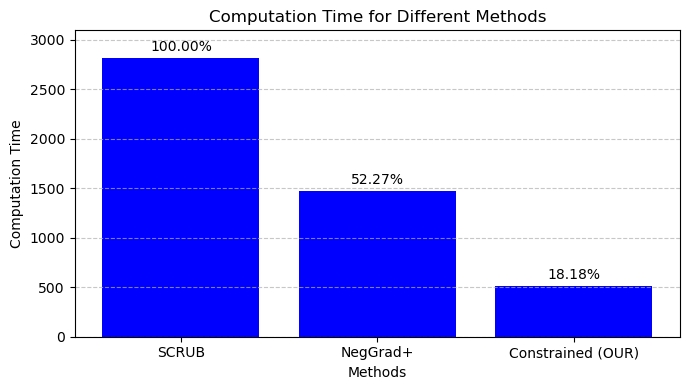

In [42]:
# Plotting
plt.figure(figsize=(7, 4))
bars = plt.bar(methods, times, color='blue')
plt.xlabel('Methods')
plt.ylabel('Computation Time')
# plt.yscale('log')
plt.title('Computation Time for Different Methods')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Annotate percentages
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    plt.annotate(f'{percentage:.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, max(height, 350)),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords='offset points',
                 ha='center', va='bottom')
    
plt.gca().margins(y=0.1)  # Increase the top margin

# Display the plot
plt.savefig('plots/comp_time_bar_2.pdf')